In [1]:
pip install --upgrade google-cloud-bigquery

     |████████████████████████████████| 174kB 4.7MB/s 
     |████████████████████████████████| 81kB 6.2MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.7.2, but you'll have google-auth 1.11.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.14.0 which is incompatible.
ERROR: google-cloud-storage 1.16.2 has requirement google-resumable-media<0.5.0dev,>=0.3.1, but you'll have google-resumable-media 0.5.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: google-cloud-core 1.0.3
    Uninstalling google-cloud-core-1.0.3:
      Successfully uninstalled google-cloud-core-1.0.3
  Found existing installation: six 1.12.0
    Uninstalling six-1.12.0:
      Successfully uninstalled six-1.12.0
  Found exist

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
client = bigquery.Client(project=project_id)

for dataset in client.list_datasets():
  print(dataset.dataset_id)

import pandas as pd

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'capstone-247602'
df_full = pd.io.gbq.read_gbq('''
SELECT * FROM `capstone-247602.combined_digital_linear.tbl_title_matching_stage_3_FINAL`''', 
project_id=project_id, verbose=False)


Digital_Data
Nielsen_Data
Separate_Aggrigated_Datasets
combined_digital_linear
predictions


/usr/local/lib/python3.6/dist-packages/pandas/io/gbq.py:176: FutureWarning: verbose is deprecated and will be removed in a future version. Set logging level in order to vary verbosity
  **kwargs


In [0]:
# imports
import math, datetime
import numpy as np
import pandas as pd
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

import matplotlib.pyplot as plt
from matplotlib import style

from scipy import stats

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import ElasticNetCV

from statsmodels.tsa.statespace.sarimax import SARIMAX

from dateutil.relativedelta import relativedelta

style.use('ggplot')

In [0]:
# VIF function
from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = SimpleImputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=10.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

def left(s, amount = 1, substring = ""):
    if (substring == ""):
        return s[:amount]
    else:
        if (len(substring) > amount):
            substring = substring[:amount]
        return substring + s[:-amount]

def right(s, amount = 1, substring = ""):
    if (substring == ""):
        return s[-amount:]
    else:
        if (len(substring) > amount):
            substring = substring[:amount]
        return s[:-amount] + substring

In [0]:
# CORR PLOT FUNCTION

from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np


def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

In [31]:
# Filter main dataframe by SHOW
# Add in calculated features
# Make airdate the index
# create dataframe of features for Average Mins Viewed and Imps

import warnings
warnings.filterwarnings("ignore")

show_name = "SUPERSTORE"
show_table = df_full[df_full.Show_Name == show_name]

show_table['days_since_last_episode'] = (show_table.groupby('Season')['airdate'].diff().fillna(0).astype(str).str[:2]).astype(str).astype(int)
show_table['days_since_1st_episode'] = ((show_table.airdate - show_table.airdate.min()).astype(str).str[:2]).astype(str).astype(int)

show_table['airdate']= pd.to_datetime(show_table['airdate']) 
show_table = show_table.set_index('airdate')


df_amv = show_table[[ 'average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                     'quarter','season_number','Season','episode_number']]

df_I = show_table[[ 'Imps','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'quarter','season_number','Season','episode_number']]

forecast_cols = ['average_mins_viewed', 'Imps']
dfs = [df_amv,df_I]

print(len(df_amv),len(df_I))
df_amv.head()

79 79


,average_mins_viewed,days_since_last_episode,days_since_1st_episode,dummy_weekday,dummy_10pm,dummy_9pm,dummy_8pm,quarter,season_number,Season,episode_number
airdate,,,,,,,,,,,
2015-11-30,4.185279e+05,0,0,1,1,0,0,4,1,2015,1
2016-01-04,8.226728e+05,35,35,1,0,0,0,1,1,2015,4
2016-01-11,9.218420e+05,7,42,1,0,0,0,1,1,2015,5
2016-01-18,9.584834e+05,7,49,1,0,0,0,1,1,2015,6
2016-01-25,1.005852e+06,7,56,1,0,0,0,1,1,2015,7


In [32]:
# remove outliers - not sure if this it right
# Graph outliers to look at them

def outliers(i):
  Q1 = i.quantile(0.25)
  Q3 = i.quantile(0.75)
  IQR = Q3 - Q1
  i = i[~((i < (Q1 - 1.5 * IQR)) |(i > (Q3 + 1.5 * IQR))).any(axis=1)]
  return i

df_amv = outliers(df_amv)
df_I = outliers(df_I)

print(len(df_amv),len(df_I))


62 62


In [33]:
# Set the X and y
# Average Mins Viewed ______________________________

forecast_col = 'average_mins_viewed'

df_amv.fillna(-99999, inplace=True)

# number to forecast out
forecast_out = 30 #int(math.ceil(0.01*len(df)))

df_amv['label'] = df_amv[forecast_col].shift(-forecast_out)
#df_amv = df_amv.drop([forecast_col],1)

# define variables
X = np.array(df_amv.drop(['label'],1))
Xv = df_amv.drop(['label'],1)

# Moved into the VIF moduale
#X = preprocessing.scale(X)
#X = X[:-forecast_out]
#X_lately = X[-forecast_out:]

df_amv.dropna(inplace=True)
y = np.array(df_amv['label'])
yv = df_amv['label']

print(len(X),len(y))


#Imps____________________________________________________________________

forecast_coli = 'Imps'

df_I.fillna(-99999, inplace=True)

# number to forecast out
forecast_out = 30 #int(math.ceil(0.01*len(df)))

df_I['label'] = df_I[forecast_coli].shift(-forecast_out)
#df_I = df_I.drop([forecast_coli],1)

# define variables
Xi = np.array(df_I.drop(['label'],1))
Xvi = df_I.drop(['label'],1)

# Moved into the VIF moduale
#Xi = preprocessing.scale(Xi)
#Xi = Xi[:-forecast_out]
#Xi_lately = Xi[-forecast_out:]

df_I.dropna(inplace=True)
yi = np.array(df_I['label'])
yvi = df_I['label']

print(len(Xi),len(yi))


62 32
62 32


In [34]:
# VIF check
# The Variance Inflation Factor (VIF) is a measure of colinearity among predictor variables within a multiple regression. 
# It is calculated by taking the the ratio of the variance of all a given model's betas divide by the variane of a single beta if it were fit alone.

transformer = ReduceVIF()


X = transformer.fit_transform(Xv[Xv.columns], yv)
X = preprocessing.scale(X)
X_all = X
X = X[:-forecast_out]
X_lately = X[-forecast_out:]

Xi = transformer.fit_transform(Xvi[Xvi.columns], yvi)
Xi = preprocessing.scale(Xi)
Xi = Xi[:-forecast_out]
Xi_lately = Xi[-forecast_out:]

print(len(X),len(X_lately),len(y))
print(len(Xi),len(Xi_lately),len(yi))

ReduceVIF fit
ReduceVIF transform
Dropping season_number with vif=inf
ReduceVIF fit
ReduceVIF transform
Dropping season_number with vif=inf
Dropping Imps with vif=6.217700842979872
32 30 32
32 30 32


In [35]:
# Split testing and training data
# Train and Test split based on date.
# Rewrite querys to exclude future data from splits

# Cross validation split
#X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size = 0.30, random_state=42)
#Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, yi ,test_size = 0.30, random_state=42)


# Time Series cross-validator
# Provides train/test indices to split time series data samples that are observed at fixed time intervals, in train/test sets. In each split, 
# test indices must be higher than before, and thus shuffling in cross validator is inappropriate.
# This cross-validation object is a variation of KFold. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.
# Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them.


tscv = TimeSeriesSplit(n_splits=int((len(y)-3)/3))

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

for train_indexi, test_indexi in tscv.split(Xi):
    print("TRAIN:", train_indexi, "TEST:", test_indexi)
    Xi_train, Xi_test = Xi[train_indexi], Xi[test_indexi]
    yi_train, yi_test = yi[train_indexi], yi[test_indexi]


# Train Model - set clf to the model you want to use

LRamv = LinearRegression(fit_intercept=True,normalize=True,copy_X=True,n_jobs=10)
LRi = LinearRegression(fit_intercept=True,normalize=True,copy_X=True,n_jobs=10)

Tamv = tree.DecisionTreeRegressor()
Ti = tree.DecisionTreeRegressor()

svmamv = svm.SVR()
svmi = svm.SVR()

Ramv = linear_model.Ridge(alpha=.5)
Ri = linear_model.Ridge(alpha=.5)

Lamv = linear_model.Lasso(alpha=0.1)
Li = linear_model.Lasso(alpha=0.1)

Namv =MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
Ni = MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

ENamv = ElasticNetCV(cv=5, random_state=0)
ENi = ElasticNetCV(cv=5, random_state=0)

# Pick model from the above options
clf = LRamv
clfi = LRi


# Fit models
clf.fit(X_train, y_train)
clfi.fit(Xi_train, yi_train)

# look up def of score functon
accuracy = clf.score(X_test, y_test)
accuracyi = clfi.score(Xi_test, yi_test)

# Forecast using the more recent data
forecast_set = clf.predict(X_lately)
forecast_seti = clfi.predict(Xi_lately)

print(forecast_set, accuracy, forecast_out, clf)
print(forecast_seti, accuracyi, forecast_out, clfi)



TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [ 8  9 10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11 12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] TEST: [20 21 22]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22] TEST: [23 24 25]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25] TEST: [26 27 28]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28] TEST: [29 30 31]
TRAIN: [0 1 2 3 4] TEST: [5 6 7]
TRAIN: [0 1 2 3 4 5 6 7] TEST: [ 8  9 10]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10] TEST: [11 12 13]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] TEST: [14 15 16]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] TEST: [17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 1

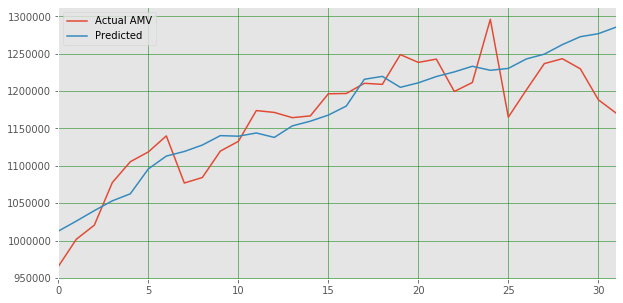

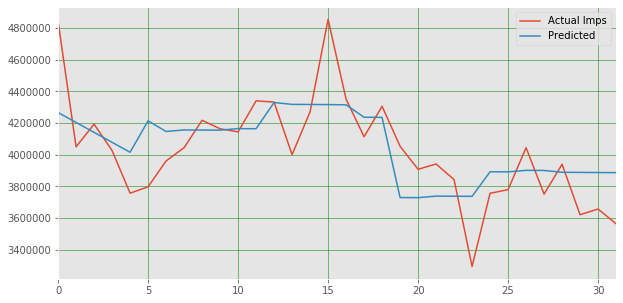

In [36]:
# Compare Tests for Accuracy
# Plot predtion and actual on line graphs
full_pred = clf.predict(X)

df_compare = pd.DataFrame({'Actual AMV': y.flatten(), 'Predicted': full_pred.flatten()})

#y_pred = clf.predict(X_test)

#df_compare = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

df1 = df_compare.head(50)
df1.plot(kind='line',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

full_predi = clfi.predict(Xi)

df_comparei = pd.DataFrame({'Actual Imps': yi.flatten(), 'Predicted': full_predi.flatten()})

#yi_pred = clfi.predict(Xi_test)

#df_comparei = pd.DataFrame({'Actual': yi_test.flatten(), 'Predicted': yi_pred.flatten()})

df1i = df_comparei.head(50)
df1i.plot(kind='line',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [0]:
# Build Forecast dataframe

df_amv['Forecast_amv'] = np.nan

# Set up forecasting dates
last_date =df_amv.iloc[-1].name
next_date = last_date+relativedelta(weeks=+1)

# add forecast rows to dataframe for Average Mins Viewed
for i in forecast_set:
  df_amv.loc[next_date] = [np.nan for _ in range(len(df_amv.columns)-1)] + [i]
  next_date = next_date+relativedelta(weeks=+1)

df_I['Forecast_I'] = np.nan

# Set up forecasting dates

last_date =df_I.iloc[-1].name
next_date = last_date+relativedelta(weeks=+1)

# add forecast rows to dataframe for Average Mins Viewed
for j in forecast_seti:
  df_I.loc[next_date] = [np.nan for _ in range(len(df_I.columns)-1)] + [j]
  next_date = next_date+relativedelta(weeks=+1)


df_I = df_I[[ 'Imps','Forecast_I']]

# Merge AMV and Imps
df = pd.merge(df_amv, df_I, left_index=True, right_index=True)

df['Percent_Digital_Viewership'] = 100 * (df.average_mins_viewed.fillna(0) + df.Forecast_amv.fillna(0)) / (df.average_mins_viewed.fillna(0) + df.Forecast_amv.fillna(0) + df.Imps.fillna(0) + df.Forecast_I.fillna(0))
df['Percent_Linear_Viewership'] = 100 * (df.Imps.fillna(0) + df.Forecast_I.fillna(0)) / (df.average_mins_viewed.fillna(0) + df.Forecast_amv.fillna(0) + df.Imps.fillna(0) + df.Forecast_I.fillna(0))


1it [00:05,  5.25s/it]


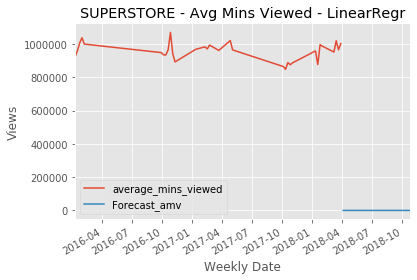

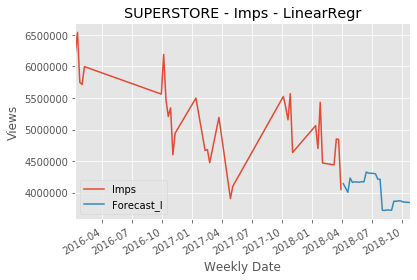

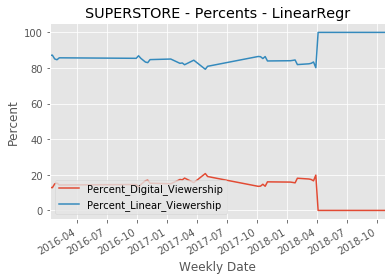

In [16]:
# Single Run

# plot the forecasts
df['airdate'] = df.index

# Write data back to Bigquery
import pandas_gbq as gbq
gbq.to_gbq(df, 'predictions.' + show_name + left(str(clf),10), project_id, if_exists='replace')

df['average_mins_viewed'].plot()
df['Forecast_amv'].plot()
plt.legend(loc=3)
plt.xlabel('Weekly Date')
plt.ylabel('Views')
plt.title(show_name + " - Avg Mins Viewed - " + left(str(clf),10))
plt.show()

df['Imps'].plot()
df['Forecast_I'].plot()
plt.legend(loc=3)
plt.xlabel('Weekly Date')
plt.ylabel('Views')
plt.title(show_name + " - Imps - " + left(str(clf),10))
plt.show()

df['Percent_Digital_Viewership'].plot()
df['Percent_Linear_Viewership'].plot()
plt.legend(loc=3)
plt.xlabel('Weekly Date')
plt.ylabel('Percent')
plt.title(show_name + " - Percents - " + left(str(clf),10))
plt.show()


In [17]:
# Test multiple models
i_results = []
amv_results = []

for clfi in [LRi,Ti,svmi,Ri,Ni,ENi]:

  # Fit models
  clfi.fit(Xi_train, yi_train)

  # look up def of score functon
  accuracyi = clfi.score(Xi_test, yi_test)

  #print(forecast_set, accuracy, forecast_out, clf)
  #print(forecast_seti, accuracyi, forecast_out, clfi)
  clf_resultsi = [left(str(clfi),10),accuracyi]
  i_results.append(clf_resultsi)


for clf in [LRamv,Tamv,svmamv,Ramv,Namv,ENamv]:

  # Fit models
  clf.fit(X_train, y_train)
  
  # look up def of score functon
  accuracy = clf.score(X_test, y_test)

  #print(forecast_set, accuracy, forecast_out, clf)
  #print(forecast_seti, accuracyi, forecast_out, clfi)
  clf_results = [left(str(clf),10),accuracy]
  amv_results.append(clf_results)

df1 = pd.DataFrame(amv_results).rename(columns={0: 'AMV Model', 1:'Accuracy'})
df2 = pd.DataFrame(i_results).rename(columns={0: 'Imps Model', 1:'Accuracy'})


print(df1)
print(df2)

    AMV Model  Accuracy
0  LinearRegr  0.998668
1  DecisionTr  0.283157
2  SVR(C=1.0,  0.293616
3  Ridge(alph  0.990336
4  MLPRegress  0.996049
5  ElasticNet  0.989011
   Imps Model   Accuracy
0  LinearRegr -25.168013
1  DecisionTr  -0.050666
2  SVR(C=1.0, -86.770825
3  Ridge(alph -27.742738
4  MLPRegress -91.702313
5  ElasticNet -91.531329


In [18]:
import warnings
warnings.filterwarnings("ignore")

# Model Eval

df = show_table[[ 'average_mins_viewed','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','quarter',]]

# Holding all other variables fixed, being a suburban area is associated with an average decrease in Sales of 106.56 widgets 
# (as compared to the baseline level, which is rural).
# Being an urban area is associated with an average increase in Sales of 268.13 widgets (as compared to rural).

feature_cols = ['days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','quarter']
X = df[feature_cols]
y = df.average_mins_viewed

# instantiate and fit
lm2 = clf
lm2.fit(X, y)

# print the coefficients
list(zip(feature_cols, lm2.coef_))

[('days_since_last_episode', 3.3392879206779016),
 ('days_since_1st_episode', -693.3630387344326),
 ('dummy_weekday', 0.0),
 ('dummy_10pm', -3.729909972642165),
 ('dummy_9pm', 0.0),
 ('dummy_8pm', 0.0),
 ('Season', 62.07786181152795),
 ('episode_number', 101.11915196450755),
 ('season_number', 62.077861832663956),
 ('quarter', 3.1789592061390683)]

In [19]:
import warnings
warnings.filterwarnings("ignore")

# Model Eval

df = show_table[[ 'Imps','days_since_last_episode','days_since_1st_episode','dummy_weekday','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number','quarter']]

# Holding all other variables fixed, being a suburban area is associated with an average decrease in Sales of 106.56 widgets 
# (as compared to the baseline level, which is rural).
# Being an urban area is associated with an average increase in Sales of 268.13 widgets (as compared to rural).

feature_cols = ['days_since_last_episode','days_since_1st_episode','dummy_10pm','dummy_9pm','dummy_8pm',
                 'Season',  'episode_number','season_number']
X = df[feature_cols]
y = df.Imps

# instantiate and fit
lm2 = clf
lm2.fit(X, y)

# print the coefficients
list(zip(feature_cols, lm2.coef_))

[('days_since_last_episode', 0.0),
 ('days_since_1st_episode', 4.44352223465652e-16),
 ('dummy_10pm', 0.0),
 ('dummy_9pm', 0.0),
 ('dummy_8pm', 0.0),
 ('Season', -0.0),
 ('episode_number', -0.0),
 ('season_number', -0.0)]